true: 3, pred: 3


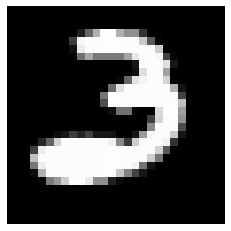

true: 2, pred: 2


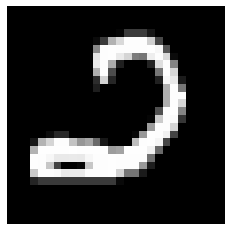

true: 0, pred: 0


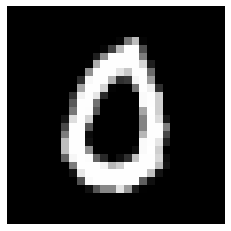

true: 9, pred: 9


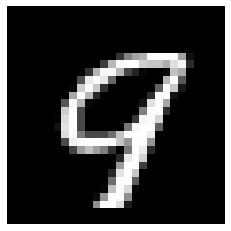

true: 0, pred: 0


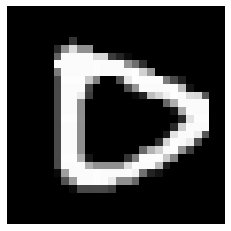

true: 6, pred: 6


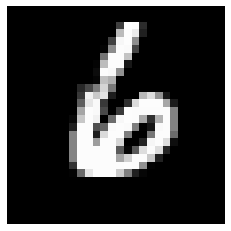

true: 1, pred: 1


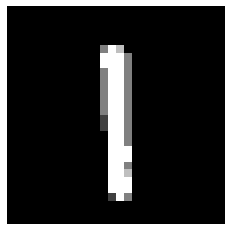

true: 1, pred: 1


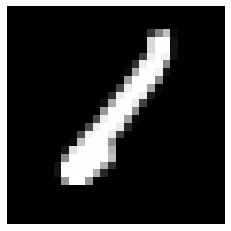

true: 4, pred: 4


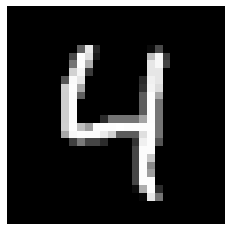

true: 8, pred: 8


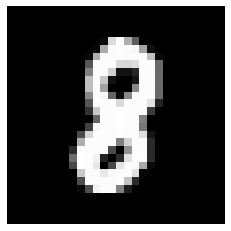

In [7]:
from torchvision import datasets, transforms
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from src import util

model = torch.load('models/cnn_mnist.pt', map_location=torch.device('cpu'))
model.eval()

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset = datasets.MNIST('data', train=False, transform=transform, download=True)
dataset_subset = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), 10, replace=False))
test_loader = torch.utils.data.DataLoader(dataset_subset, batch_size=1, shuffle=False)

single_instance = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), 2, replace=False))
single_loader = torch.utils.data.DataLoader(single_instance, batch_size=1, shuffle=False)

for image, label in test_loader:
    pred = model(image).argmax(axis=1)
    npimg = np.squeeze(np.squeeze(image.numpy()))
    plt.imshow(npimg, cmap='gray')
    print(f'true: {label[0]}, pred: {pred[0]}')
    plt.axis('off')
    plt.show()

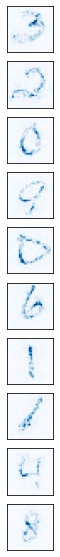

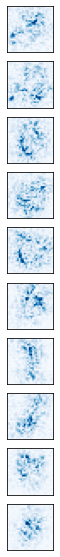

In [40]:
# visualize integrated gradients for mnist cnn

import torchvision
from captum.attr import IntegratedGradients, Saliency, InputXGradient, GuidedBackprop, GuidedGradCam
from captum.attr import visualization as viz

def attribute_image_features(algorithm, input, label, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input, target=label, **kwargs)
    
    return tensor_attributions


# Given a NN model, ...
def visualize_saliency_method(model, saliency_kwargs, image, plt_fig_axis):
    image.requires_grad = True
    attrs = attribute_image_features(**saliency_kwargs)
    attrs = np.transpose(attrs.squeeze(0).cpu().detach().numpy(), (1,2,0))
    original_image = np.transpose(image.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    return viz.visualize_image_attr(attrs, original_image, method="heat_map",sign="absolute_value",
                          plt_fig_axis=plt_fig_axis, cmap="Blues", show_colorbar=False,
                          use_pyplot=False)


ig = IntegratedGradients
fig, axs = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(10, 10))
for (image, label), row in zip(test_loader, range(len(test_loader))):
    ig_kwargs = {
        'algorithm': ig(model),
        'input': image,
        'label': label,
        'baselines': image * 0} # stuff specific to integrated gradients
    fig, _ = visualize_saliency_method(model, ig_kwargs, image, (fig, axs[row]))
plt.show(fig)

sal = Saliency
fig, axs = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(10, 10))
for (image, label), row in zip(test_loader, range(len(test_loader))):
    sal_kwargs = {
        'algorithm': sal(model),
        'input': image,
        'label': label,
    } # stuff specific to gradients (saliency)
    fig, _ = visualize_saliency_method(model, sal_kwargs, image, (fig, axs[row]))
plt.show(fig)

In [41]:
def get_kwargs(saliency_method, model, image, label):
    sal_kwargs = {
        'input': image,
        'label': label,
    }
    
    if saliency_method == IntegratedGradients:
        sal_kwargs.update({
            'algorithm': saliency_method(model),
            'baselines': image * 0
        })
    elif saliency_method == Saliency:
        sal_kwargs.update({
            'algorithm': saliency_method(model),
        })
    elif saliency_method == InputXGradient:
        sal_kwargs.update({
            'algorithm': saliency_method(model),
        })
    elif saliency_method == GuidedBackprop:
        sal_kwargs.update({
            'algorithm': saliency_method(model),
        })
    elif saliency_method == GuidedGradCam:
        sal_kwargs.update({
            'algorithm': saliency_method(model, model.conv2)
        })
    else:
        raise Exception("Saliency method not supported :(")
    
    return sal_kwargs

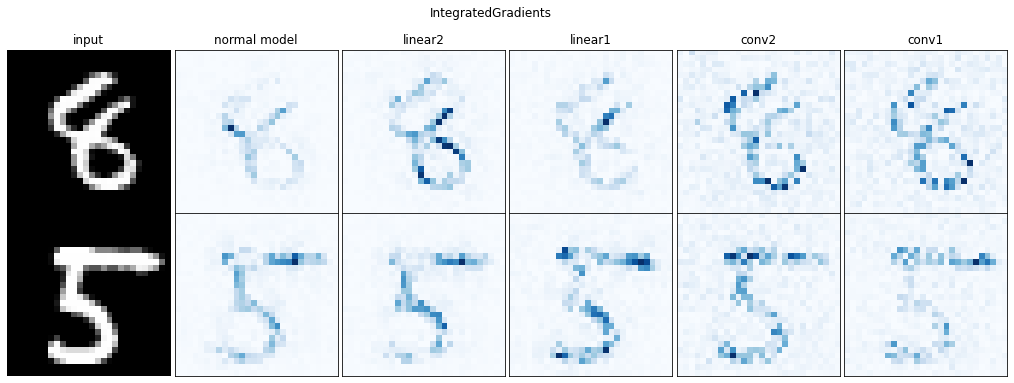

In [42]:
def visualize_cascading_randomization(model, module_paths, examples, saliency_method):
    model_copy = copy.deepcopy(model)
    
    # make plt plot
    nrows = len(examples)
    ncols = len(module_paths) + 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
    fig.subplots_adjust(hspace=0, wspace=0)
    
    # show input image at the very left
    for (image, _), row in zip(examples, range(nrows)):
        npimg = np.squeeze(np.squeeze(image.numpy()))
        axs[row, 0].imshow(npimg, cmap='gray')
        axs[row, 0].axis('off')
    
    # show visualizations before scrambling the model
    for (image, label), row in zip(examples, range(nrows)):
        pred = model_copy(image).argmax(axis=1).item()
        sal_kwargs = get_kwargs(saliency_method, model_copy, image, label)
        fig, _ = visualize_saliency_method(model_copy, sal_kwargs, image, (fig, axs[row, 1]))

    # cascading randomization and visualization of IG
    # start with 1 because 0th column is unscrambled model
    for path, col in zip(module_paths, range(2, ncols)):
        util.rand_layers(model_copy, [path])
        for (image, label), row in zip(examples, range(nrows)):
            pred = model_copy(image).argmax(axis=1).item()
            sal_kwargs = get_kwargs(saliency_method, model_copy, image, label)
            fig, _ = visualize_saliency_method(model_copy, sal_kwargs, image, (fig, axs[row, col]))
    
    # set titles for each column
    col_titles = ['input', 'normal model'] + [x for x in map((lambda x: '_'.join(x)), module_paths)]
    for ax, col in zip(axs[0], col_titles):
        ax.set_title(col)
    
    # set title for the whole thing
    fig.suptitle(saliency_method.__name__)


module_paths = [['linear2'], ['linear1'], ['conv2'], ['conv1']]
visualize_cascading_randomization(model, module_paths, single_loader, IntegratedGradients)

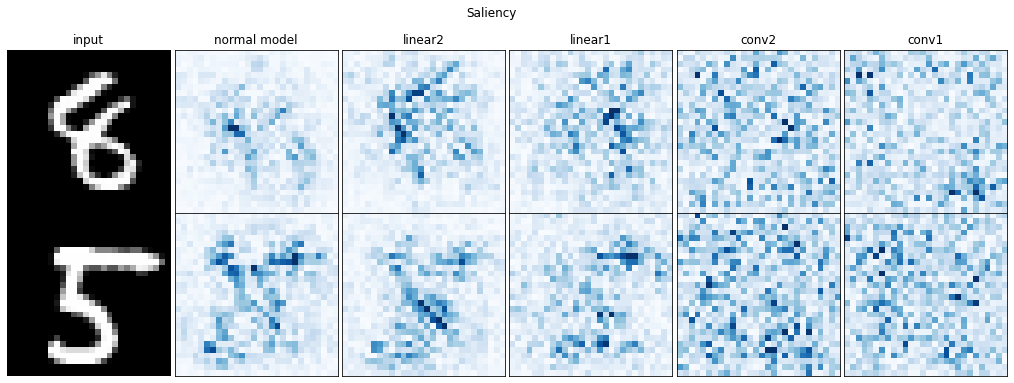

In [43]:
visualize_cascading_randomization(model, module_paths, single_loader, Saliency)

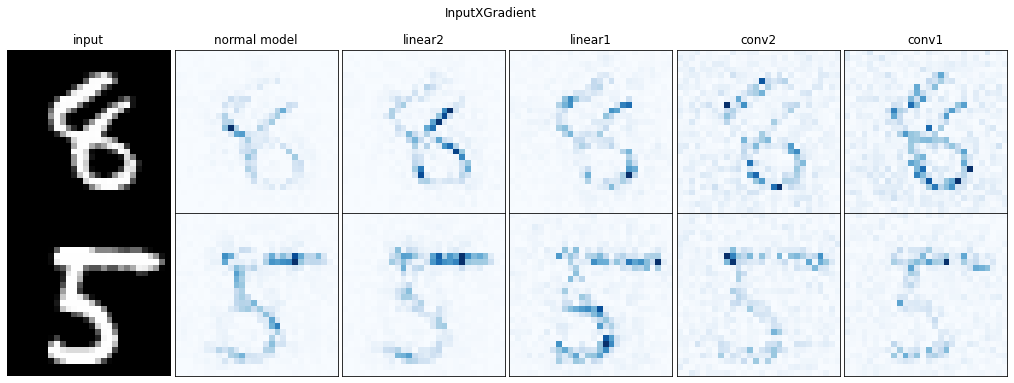

In [44]:
visualize_cascading_randomization(model, module_paths, single_loader, InputXGradient)

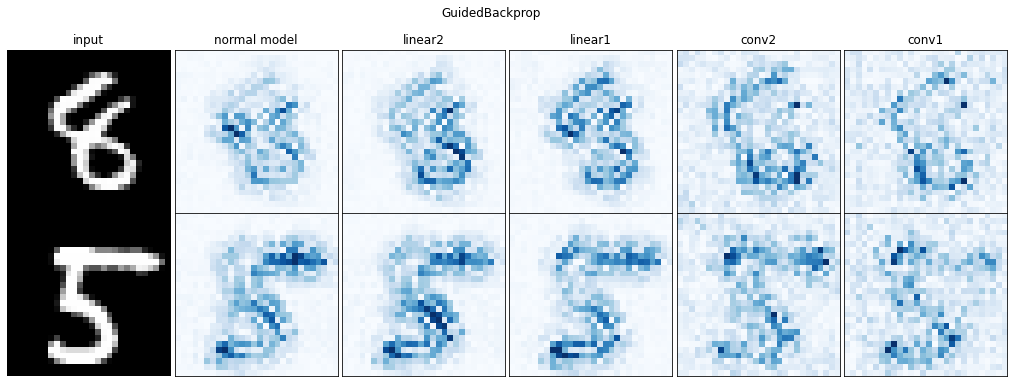

In [45]:
visualize_cascading_randomization(model, module_paths, single_loader, GuidedBackprop)

AssertionError: Cannot normalize by scale factor = 0

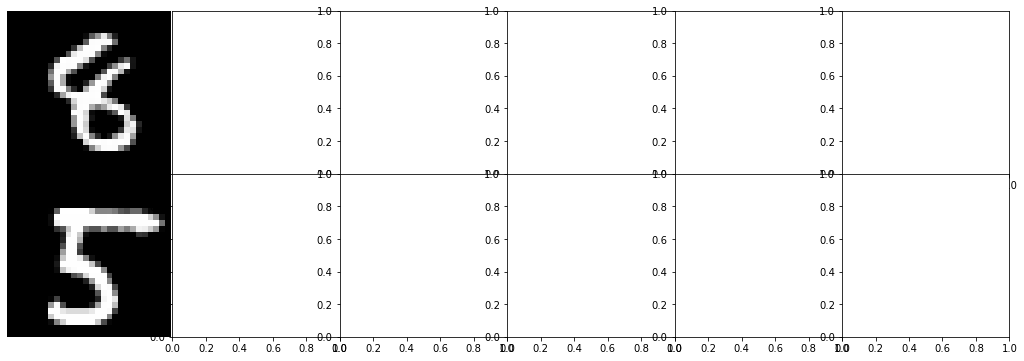

In [46]:
visualize_cascading_randomization(model, module_paths, single_loader, GuidedGradCam)